## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI2D-sagittal' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
diagonal_wavelet_sagittal_syntheticMRI2D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI2D/sagittal/wavelet/diagonal'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 0,
 3: 3396,
 4: 98808,
 5: 524004,
 6: 2418270,
 7: 10234344,
 8: 42110360,
 9: 170911996}

Running 12760 CDFs


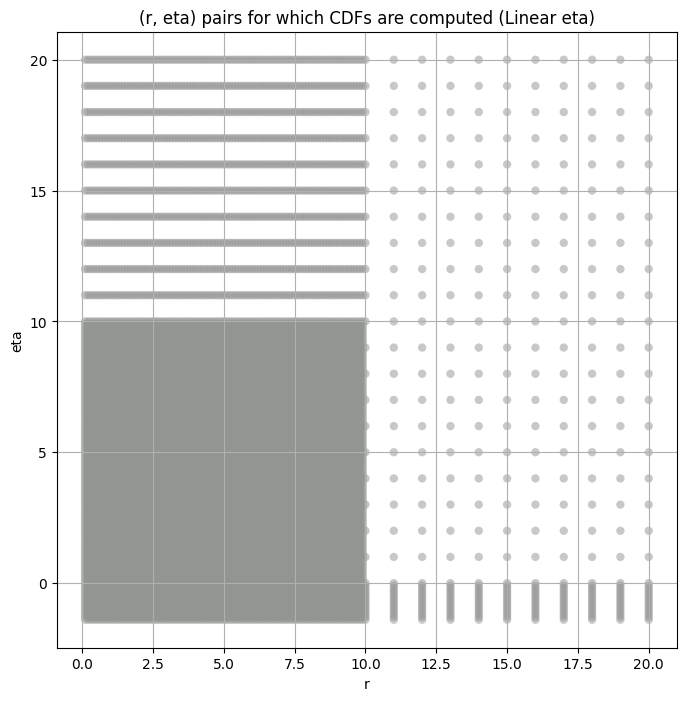

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var      var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2               NaN            NaN            NaN         NaN         NaN   
3      269730.25000  256567.560000  283191.780000   -0.762905   -0.865668   
4      175429.64000  167353.880000  183664.520000    1.248459    1.072484   
5       35103.45300   33078.260000   37192.094000    3.165878    2.714671   
6       13483.66600   12302.890000   14720.538000   10.163432    8.836062   
7        2081.28400    1881.258400    2294.593500   12.775476   10.799274   
8         127.34690     112.202866     150.385480   29.678112   10.853311   
9           5.91954       4.214583      11.399667  575.520200   13.528171   

        kurt_upper  total_samples  
layer                              
2              NaN              0  
3        -0.650419           3396  
4         1.431778          98808  
5         3.686968         524004  
6        11.496545        2418270  
7        14.925213       10234344  
8       114.303610       42110360  
9      1555.118400      170911996

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2               NaN            NaN             NaN             NaN   
3      269730.25000  269730.250000   250540.031250   237115.812500   
4      175429.64000  175429.640625   174076.625000   172893.828125   
5       35103.45300   35103.453125    34610.738281    34230.496094   
6       13483.66600   13483.666016    13144.615234    12853.903320   
7        2081.28400    2081.283936     2013.042480     1958.305786   
8         127.34690     127.346901      118.363564      114.653473   
9           5.91954       5.919540        4.365947        4.174627   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2                 NaN              NaN              NaN              NaN   
3       226328.671875    216467.859375    199017.750000    184075.328125   
4       171786.203125    170718.453125    168734.359375    166858.703125   
5        33884.964844     33564.917969     32974.425781     32434.222656   
6        12587.685547     12338.569336     11880.536133     11467.692383   
7         1910.192383      1866.785522      1790.228149      1723.519165   
8          111.617508       108.987175       104.497269       100.682770   
9            4.038084         3.927097         3.747960         3.603436   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2                  NaN              NaN              NaN              NaN  
3        170563.671875    158218.296875    146798.437500    116672.375000  
4        165068.546875    163352.437500    161684.796875    156983.093750  
5         31929.707031     31454.009766     31004.388672     29776.369141  
6         11095.803711     10760.933594     10457.120117      9685.037109  
7          1663.943237      1609.911133      1560.351440      1432.382812  
8            97.326118        94.313454        91.576393        84.597893  
9             3.480754         3.373473         3.277795         3.039025

####
Layer  2
####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.04895924240911709 269730.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.05619078623508694 250540.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.06185576000295823 237115.81


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.06671157610122669 226328.67


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.07157508208630844 216467.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.08132917112034971 199017.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.09049522997850223 184075.33


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.09950449729783606 170563.67


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.10845212124777173 158218.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.11738320461697827 146798.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.1447656339549463 116672.375
Number of samples: 3396, Without approximation : 3396


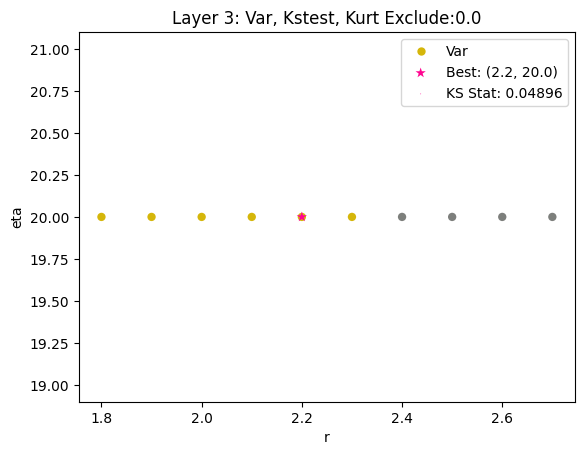

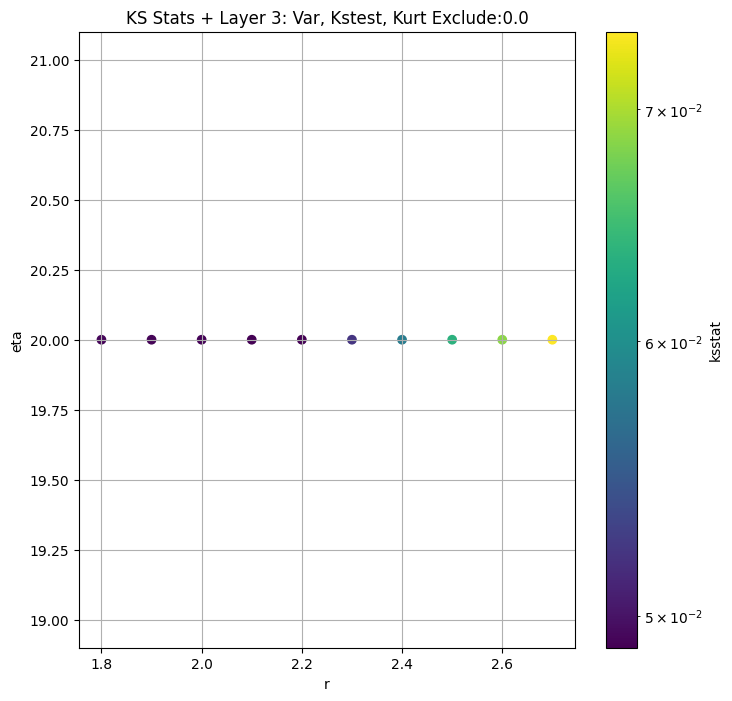

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.014235918703384327 175429.64


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.014235918703384327 174076.62


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.014235918703384327 172893.83


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.014235918703384327 171786.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.014235918703384327 170718.45


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.014235918703384327 168734.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.014235918703384327 166858.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.014235918703384327 165068.55


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.014235918703384327 163352.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.014235918703384327 161684.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.013879149807376256 156983.1
Number of samples: 98808, Without approximation : 98808


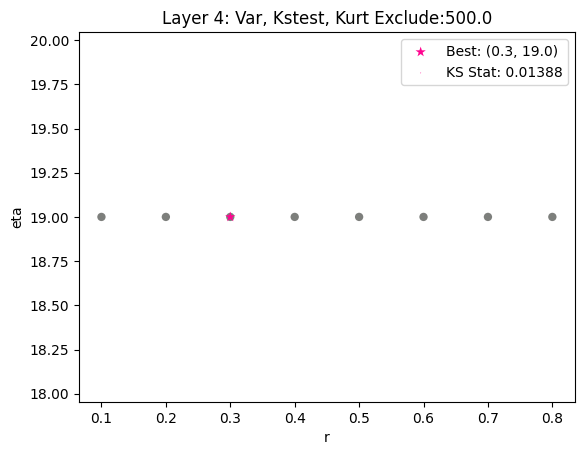

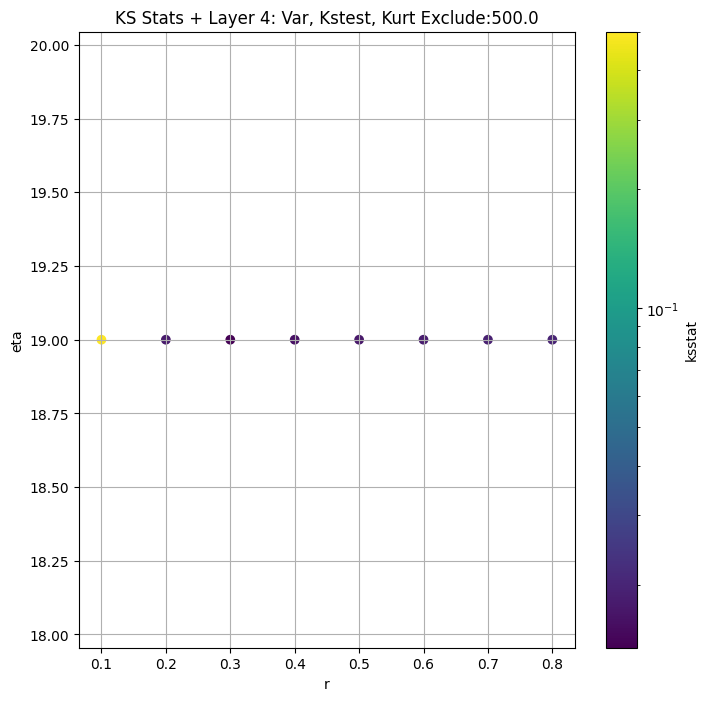

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.006666394320555991 35103.453


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.00599419194213275 34610.74


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.006581610932151705 34230.496


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.007118358441184913 33884.965


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.00761755932866489 33564.918


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.00738342475370779 32974.426


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.007866235822357653 32434.223


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.008387303352811126 31929.707


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.008921588457471707 31454.01


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.009474971746359917 31004.389


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.010249397192280109 29776.37
Number of samples: 100000, Without approximation : 524004


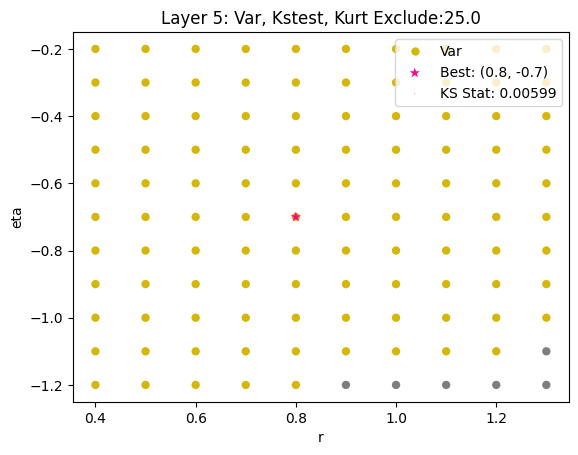

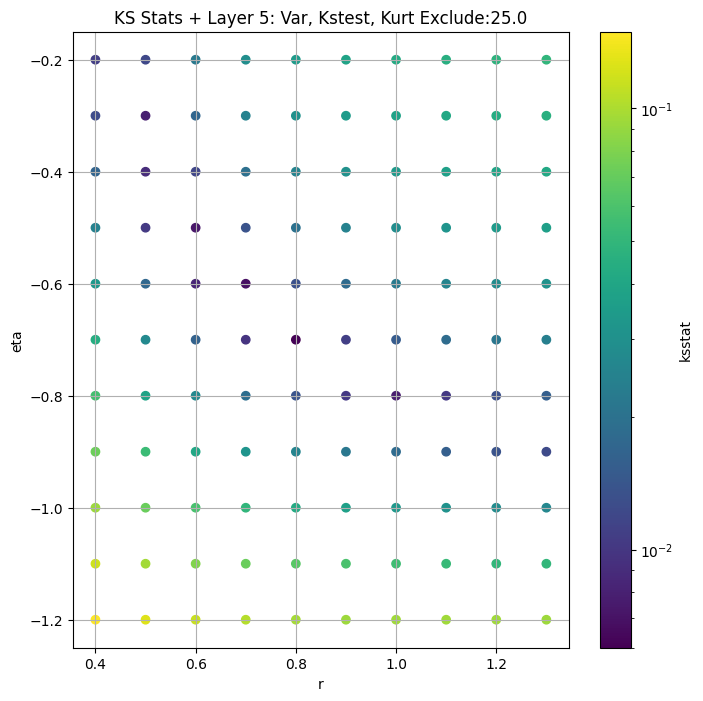

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.004855076530537655 13483.666


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.004930396474193466 13144.615


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.0044893991500348784 12853.903


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.003776056604718806 12587.686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.004150966214230761 12338.569


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.004896791712680537 11880.536


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.005136966067207151 11467.692


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.005869791846980842 11095.804


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.006188712770853089 10760.934


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.006856158683637981 10457.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.008573849622257934 9685.037
Number of samples: 100000, Without approximation : 2418270


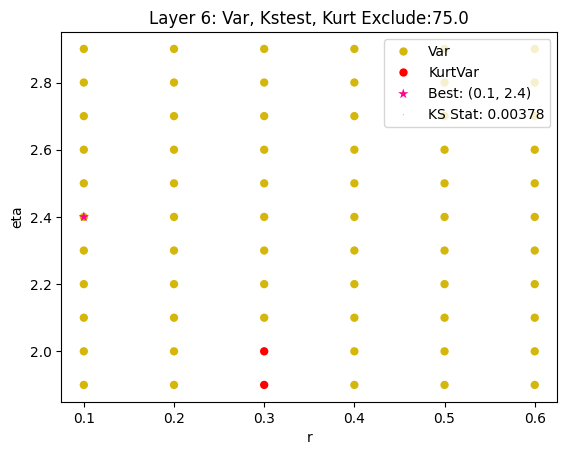

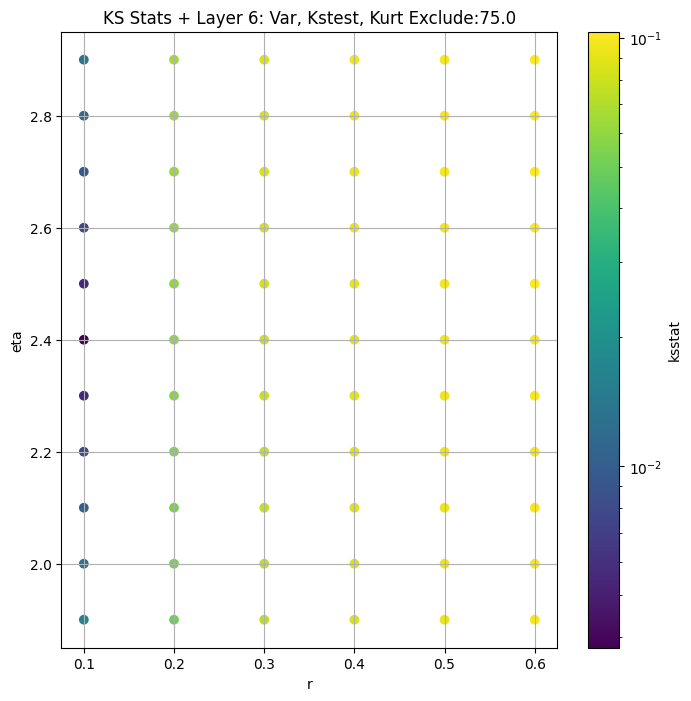

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.0058177871238473955 2081.284


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.005289209352555946 2013.0425


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.004353537964491394 1958.3058


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.003491153704060168 1910.1924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.0038261111616456622 1866.7855


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.004420161728265218 1790.2281


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.0048433600192314685 1723.5192


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.005320097177279366 1663.9432


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.00575578312120519 1609.9111


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.006251963325212545 1560.3514


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.007846922813347423 1432.3828
Number of samples: 100000, Without approximation : 10234344


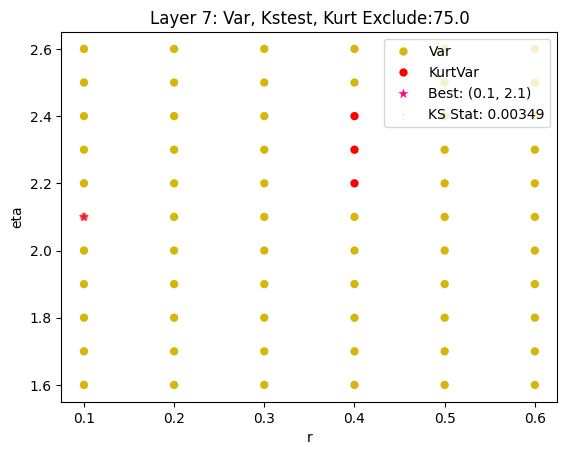

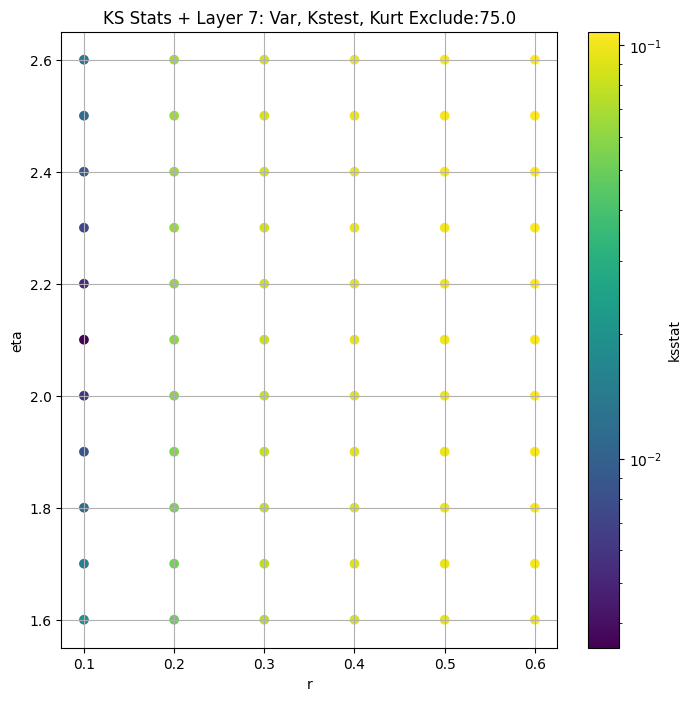

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.0054503459326977755 127.3469


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.004416194132683238 118.36356


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.0038349805994996045 114.65347


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.0031191060852735486 111.61751


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.0032912513105674973 108.987175


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.003944212248555207 104.49727


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.0044389814246681425 100.68277


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.004867440977531778 97.32612


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.005494977069473883 94.31345


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.005987884882324157 91.57639


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.007816699026482077 84.59789
Number of samples: 100000, Without approximation : 42110360


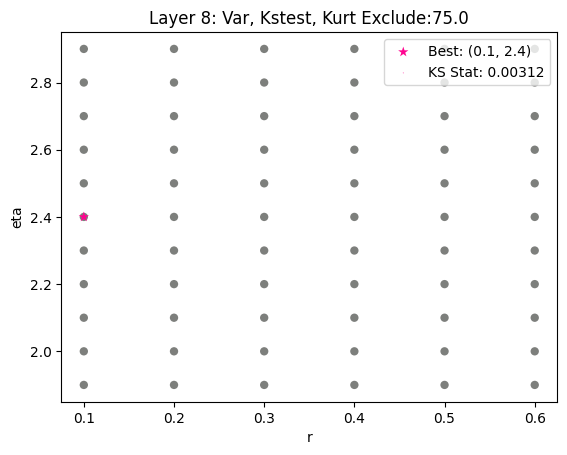

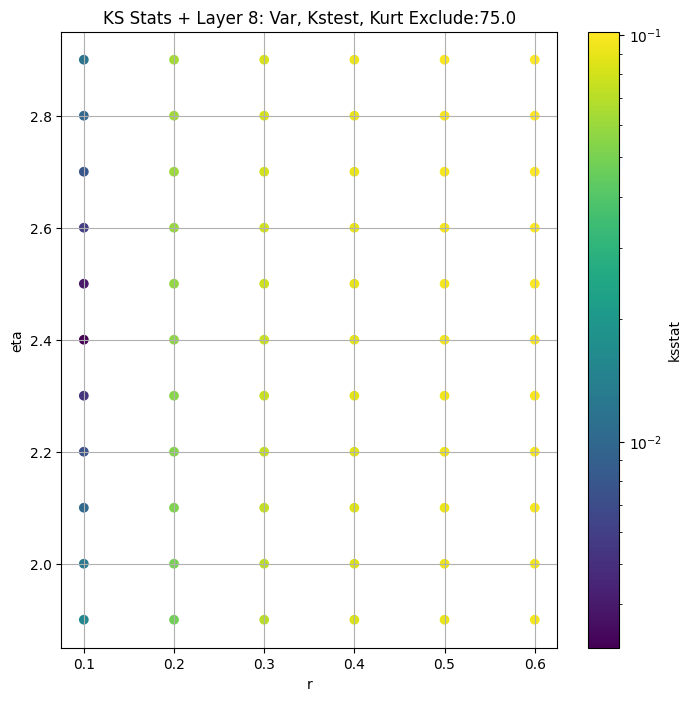

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.016348487186876648 5.91954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.009552675773668431 4.3659472


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.008574617380624816 4.1746273


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.007674108668847046 4.038084


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.007214833929017117 3.9270973


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.005778109353292926 3.74796


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.005269476592238198 3.6034355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.005359912672707162 3.4807544


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.005798345728440402 3.3734727


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.006496394633474845 3.277795


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.008085495193434048 3.0390246
Number of samples: 100000, Without approximation : 170911996


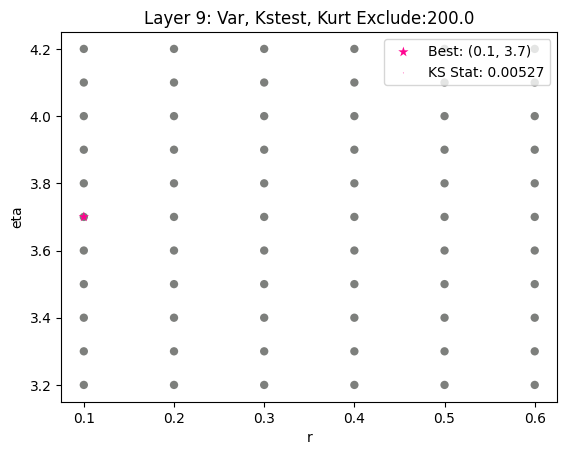

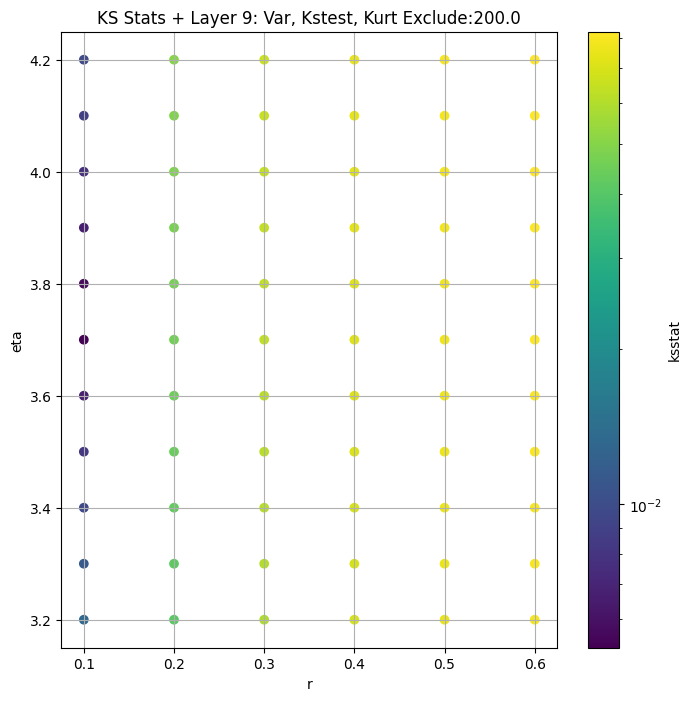

obs_var      var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2               NaN            NaN            NaN         NaN         NaN   
3      269730.25000  256567.560000  283191.780000   -0.762905   -0.865668   
4      175429.64000  167353.880000  183664.520000    1.248459    1.072484   
5       35103.45300   33078.260000   37192.094000    3.165878    2.714671   
6       13483.66600   12302.890000   14720.538000   10.163432    8.836062   
7        2081.28400    1881.258400    2294.593500   12.775476   10.799274   
8         127.34690     112.202866     150.385480   29.678112   10.853311   
9           5.91954       4.214583      11.399667  575.520200   13.528171   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2              NaN              0                  NaN        NaN   
3        -0.650419           3396             0.048959        2.2   
4         1.431778          98808             0.013879        0.3   
5         3.686968         524004             0.005994        0.8   
6        11.496545        2418270             0.003776        0.1   
7        14.925213       10234344             0.003491        0.1   
8       114.303610       42110360             0.003119        0.1   
9      1555.118400      170911996             0.005269        0.1   

       initial_eta  initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                                           
2              NaN            NaN                     NaN                 NaN   
3             20.0   9.692541e+04                     0.0       269730.250000   
4             19.0   1.137705e-01                   500.0       156983.100000   
5             -0.7   3.054779e+04                    25.0        34610.740000   
6              2.4   5.303439e-13                    75.0        12587.686000   
7              2.1   1.650053e-13                    75.0         1910.192400   
8              2.4   4.702665e-15                    75.0          111.617510   
9              3.7   1.101177e-17                   200.0            3.603435   

       kstest_stat_cutoff_0.05  
layer                           
2                          NaN  
3                     0.023255  
4                     0.004319  
5                     0.001876  
6                     0.000873  
7                     0.000425  
8                     0.000209  
9                     0.000104

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2
Layer 3


  0%|          | 0/36 [00:00<?, ?it/s]

Finding Minimum after computing 36 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.07157508208630844, var: 216467.859375


  0%|          | 0/36 [00:00<?, ?it/s]

Finding Minimum after computing 36 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.06671157610122669, var: 226328.671875


  0%|          | 0/36 [00:00<?, ?it/s]

Finding Minimum after computing 36 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.06185576000295823, var: 237115.8125


  0%|          | 0/36 [00:00<?, ?it/s]

Finding Minimum after computing 36 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.05619078623508694, var: 250540.03125


  0%|          | 0/36 [00:00<?, ?it/s]

Finding Minimum after computing 36 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.04895924240911709, var: 269730.25
Number of samples: 3396, Without approximation : 3396


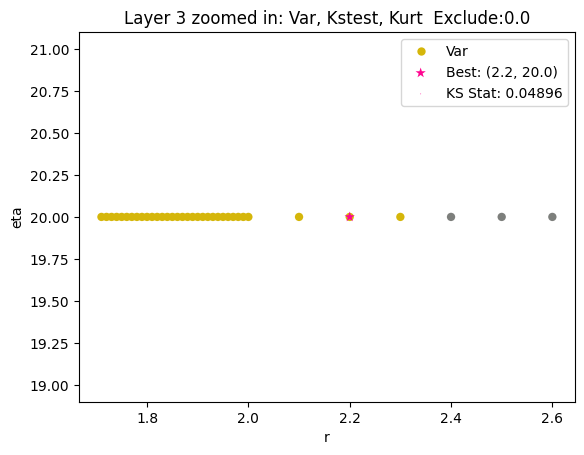

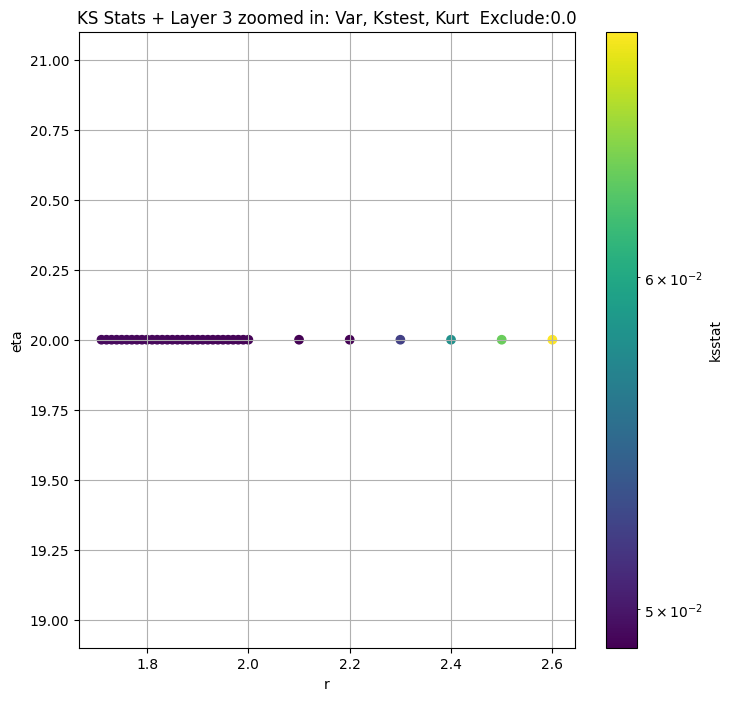

Layer 4


  0%|          | 0/77 [00:00<?, ?it/s]

Finding Minimum after computing 77 CDFs
layer 4, 500.0 + 100 = 600, ksstat: 0.013932293017797298, var: 154074.03125


  0%|          | 0/77 [00:00<?, ?it/s]

Finding Minimum after computing 77 CDFs
layer 4, 500.0 + 75 = 575, ksstat: 0.013733088343086952, var: 154787.3125


  0%|          | 0/77 [00:00<?, ?it/s]

Finding Minimum after computing 77 CDFs
layer 4, 500.0 + 50 = 550, ksstat: 0.013751258409185563, var: 155509.671875


  0%|          | 0/77 [00:00<?, ?it/s]

Finding Minimum after computing 77 CDFs
layer 4, 500.0 + 25 = 525, ksstat: 0.013817526706904282, var: 156241.53125


  0%|          | 0/77 [00:00<?, ?it/s]

Finding Minimum after computing 77 CDFs
layer 4, 500.0 + 0 = 500, ksstat: 0.013879149807376256, var: 156983.09375


  0%|          | 0/77 [00:00<?, ?it/s]

Finding Minimum after computing 77 CDFs
layer 4, 500.0 + -25 = 475, ksstat: 0.01408249421093588, var: 157735.09375


  0%|          | 0/77 [00:00<?, ?it/s]

Finding Minimum after computing 77 CDFs
layer 4, 500.0 + -50 = 450, ksstat: 0.014082764642933454, var: 158498.671875


  0%|          | 0/77 [00:00<?, ?it/s]

Finding Minimum after computing 77 CDFs
layer 4, 500.0 + -75 = 425, ksstat: 0.014181990428369318, var: 159276.0


  0%|          | 0/77 [00:00<?, ?it/s]

Finding Minimum after computing 77 CDFs
layer 4, 500.0 + -100 = 400, ksstat: 0.014356870072735728, var: 160064.671875
Number of samples: 98808, Without approximation : 98808


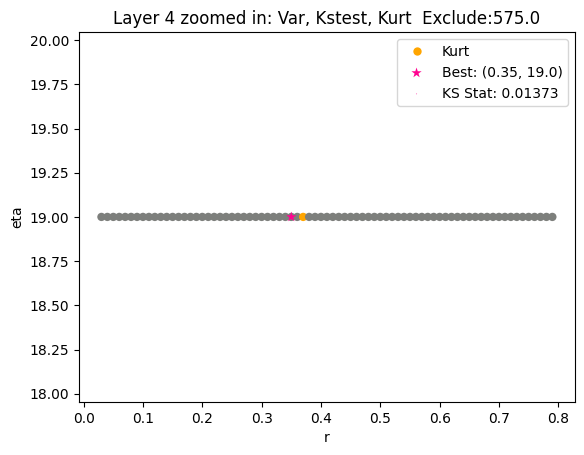

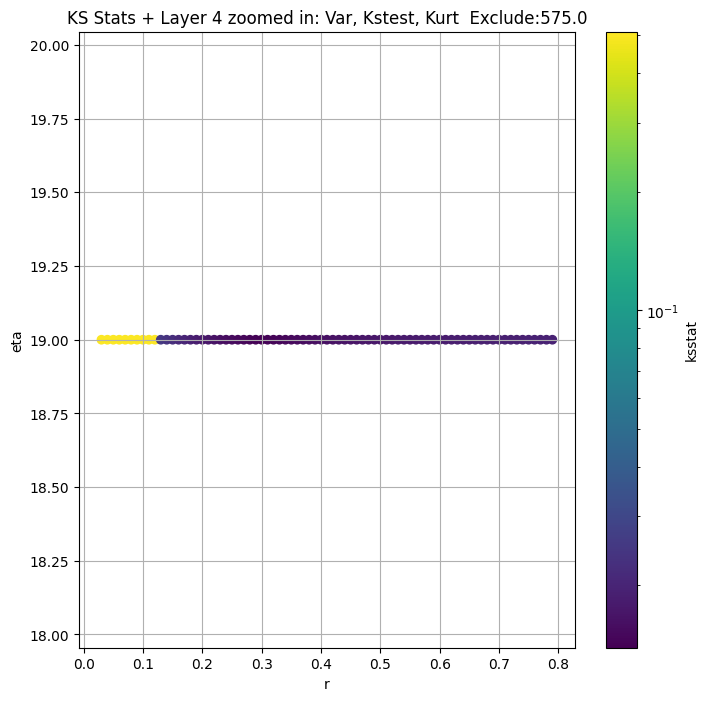

Layer 5


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 25.0 + 100 = 125, ksstat: 0.006992529715727926, var: 33262.4453125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 25.0 + 75 = 100, ksstat: 0.006927312229206138, var: 33564.91796875


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 25.0 + 50 = 75, ksstat: 0.006509916561170059, var: 33884.96484375


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 25.0 + 25 = 50, ksstat: 0.006402113643997898, var: 34230.49609375


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 25.0 + 0 = 25, ksstat: 0.00599419194213275, var: 34610.73828125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 5, 25.0 + -25 = 0, ksstat: 0.0058224441622601875, var: 35103.453125
Number of samples: 100000, Without approximation : 524004


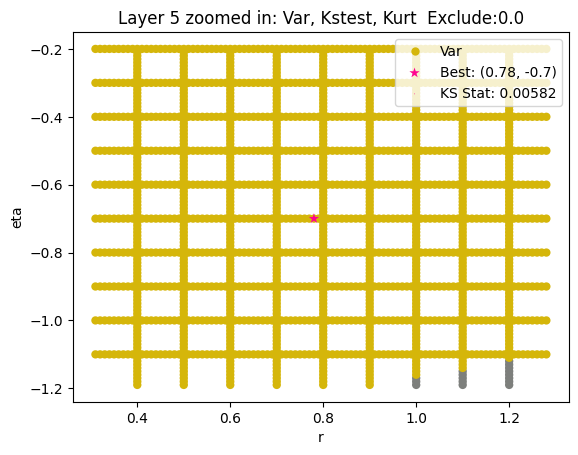

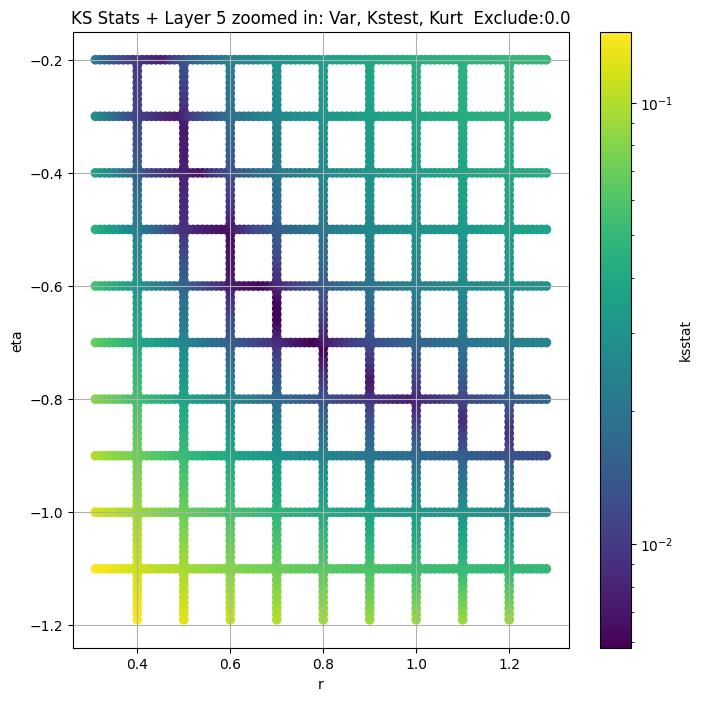

Layer 6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 75.0 + 100 = 175, ksstat: 0.005170930051303261, var: 11668.8232421875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 75.0 + 75 = 150, ksstat: 0.004883377407161826, var: 11880.5361328125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 75.0 + 50 = 125, ksstat: 0.004465573526561403, var: 12103.560546875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 75.0 + 25 = 100, ksstat: 0.004099396943798055, var: 12338.5693359375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 75.0 + 0 = 75, ksstat: 0.003776056604718806, var: 12587.685546875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 75.0 + -25 = 50, ksstat: 0.0038666976282407117, var: 12853.9033203125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 75.0 + -50 = 25, ksstat: 0.004074833526622856, var: 13144.615234375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 75.0 + -75 = 0, ksstat: 0.004781077543547063, var: 13483.666015625
Number of samples: 100000, Without approximation : 2418270


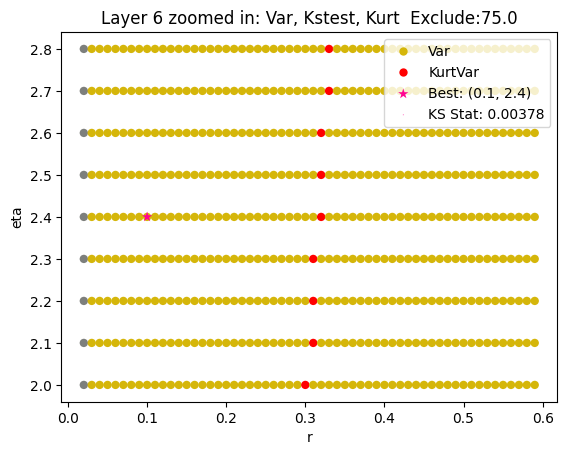

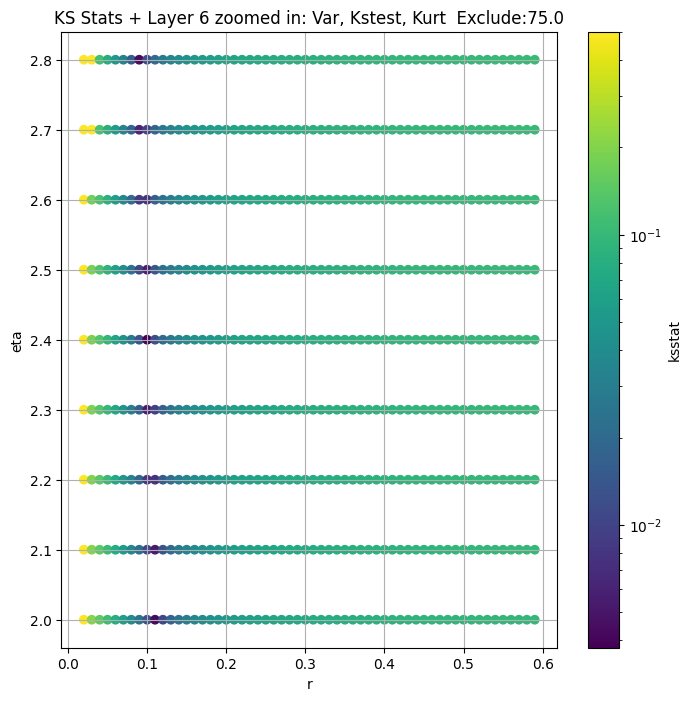

Layer 7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 75.0 + 100 = 175, ksstat: 0.004676515732452424, var: 1755.82763671875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 75.0 + 75 = 150, ksstat: 0.004393769323789765, var: 1790.2281494140625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 75.0 + 50 = 125, ksstat: 0.004106521034491767, var: 1827.0277099609375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 75.0 + 25 = 100, ksstat: 0.003784706584282654, var: 1866.7855224609375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 75.0 + 0 = 75, ksstat: 0.003491153704060168, var: 1910.1923828125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 75.0 + -25 = 50, ksstat: 0.004353537964491394, var: 1958.3057861328125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 75.0 + -50 = 25, ksstat: 0.004724291557339222, var: 2013.04248046875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 75.0 + -75 = 0, ksstat: 0.0054249972011148895, var: 2081.283935546875
Number of samples: 100000, Without approximation : 10234344


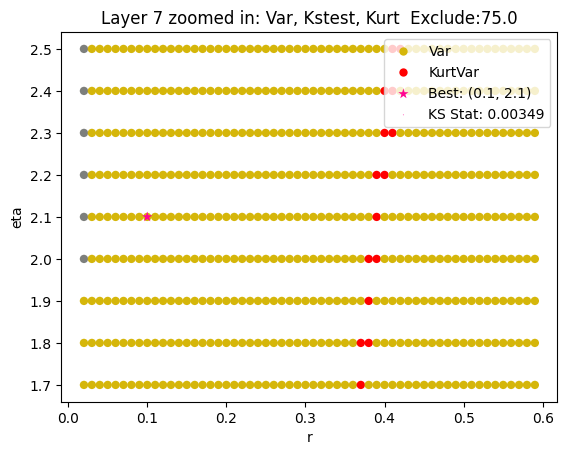

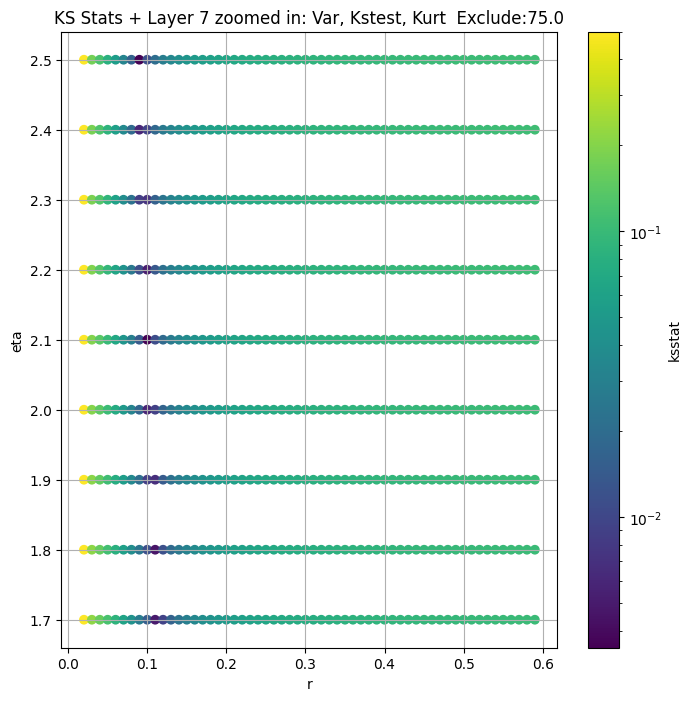

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 75.0 + 100 = 175, ksstat: 0.004391536523416173, var: 102.52236938476562


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 75.0 + 75 = 150, ksstat: 0.004002942880553251, var: 104.49726867675781


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 75.0 + 50 = 125, ksstat: 0.003655737984763492, var: 106.6371841430664


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 75.0 + 25 = 100, ksstat: 0.0032453089849686697, var: 108.98717498779297


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 75.0 + 0 = 75, ksstat: 0.0031191060852735486, var: 111.61750793457031


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 75.0 + -25 = 50, ksstat: 0.0027799857345577883, var: 114.65347290039062


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 75.0 + -50 = 25, ksstat: 0.003528578896169199, var: 118.36356353759766


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 75.0 + -75 = 0, ksstat: 0.0054503459326977755, var: 127.3469009399414
Number of samples: 100000, Without approximation : 42110360


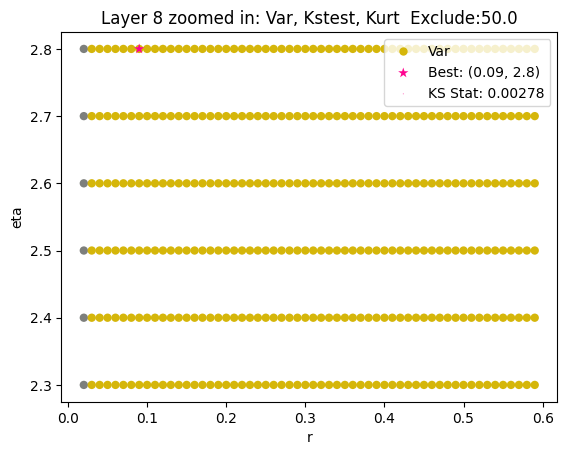

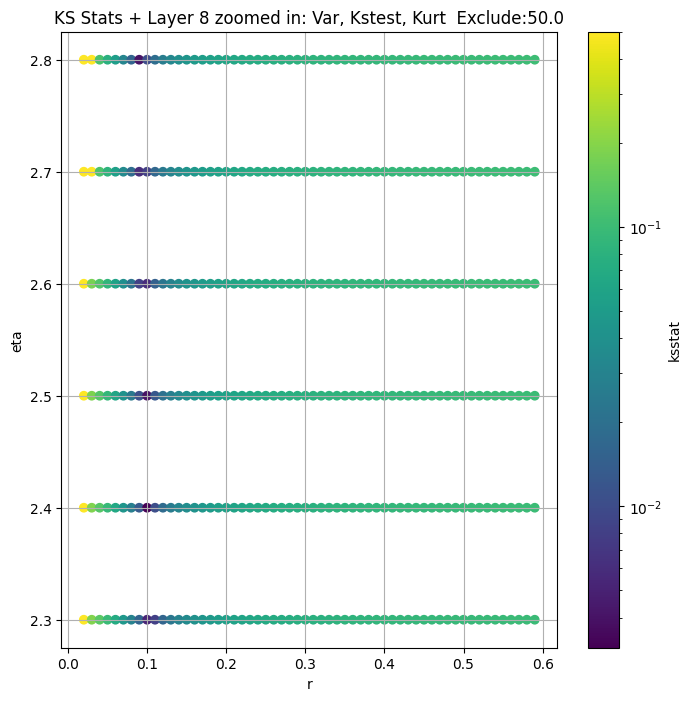

Layer 9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 100 = 300, ksstat: 0.006066074550227896, var: 3.3734726905822754


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 75 = 275, ksstat: 0.005691281845638274, var: 3.4254605770111084


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 50 = 250, ksstat: 0.005330412786970839, var: 3.4807543754577637


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 25 = 225, ksstat: 0.004983059358185316, var: 3.539856195449829


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 0 = 200, ksstat: 0.005269476592238198, var: 3.603435516357422


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -25 = 175, ksstat: 0.00553924043765075, var: 3.6724002361297607


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -50 = 150, ksstat: 0.005695502966445998, var: 3.747960090637207


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -75 = 125, ksstat: 0.006400163882195387, var: 3.8319523334503174


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -100 = 100, ksstat: 0.006747890485587105, var: 3.9270973205566406
Number of samples: 100000, Without approximation : 170911996


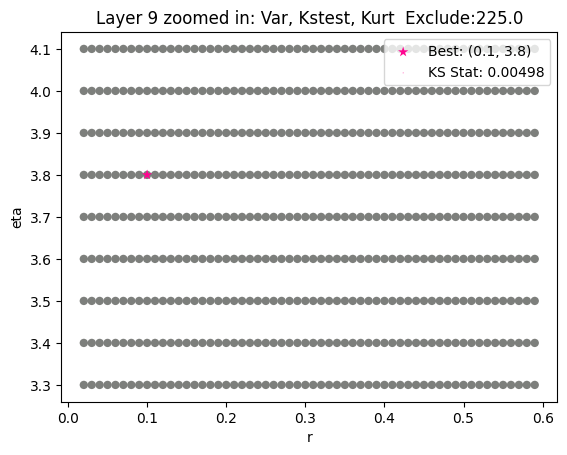

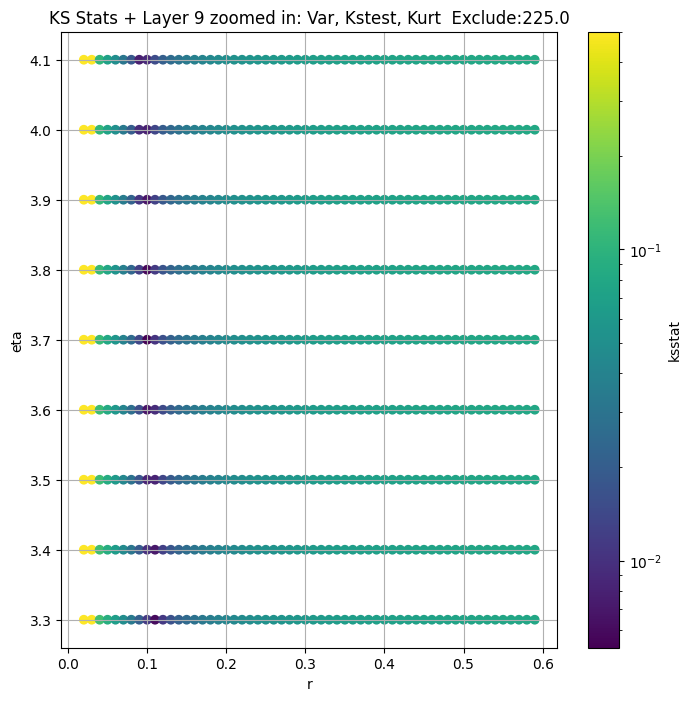

Cannot compute pval with ksstat : nan, n : 0.0


obs_var      var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2               NaN            NaN            NaN         NaN         NaN   
3      269730.25000  256567.560000  283191.780000   -0.762905   -0.865668   
4      175429.64000  167353.880000  183664.520000    1.248459    1.072484   
5       35103.45300   33078.260000   37192.094000    3.165878    2.714671   
6       13483.66600   12302.890000   14720.538000   10.163432    8.836062   
7        2081.28400    1881.258400    2294.593500   12.775476   10.799274   
8         127.34690     112.202866     150.385480   29.678112   10.853311   
9           5.91954       4.214583      11.399667  575.520200   13.528171   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2              NaN              0                  NaN        NaN   
3        -0.650419           3396             0.048959        2.2   
4         1.431778          98808             0.013879        0.3   
5         3.686968         524004             0.005994        0.8   
6        11.496545        2418270             0.003776        0.1   
7        14.925213       10234344             0.003491        0.1   
8       114.303610       42110360             0.003119        0.1   
9      1555.118400      170911996             0.005269        0.1   

       initial_eta  initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                                           
2              NaN            NaN                     NaN                 NaN   
3             20.0   9.692541e+04                     0.0       269730.250000   
4             19.0   1.137705e-01                   500.0       154787.312500   
5             -0.7   3.054779e+04                    25.0        35103.453125   
6              2.4   5.303439e-13                    75.0        12587.686000   
7              2.1   1.650053e-13                    75.0         1910.192400   
8              2.4   4.702665e-15                    75.0          114.653473   
9              3.7   1.101177e-17                   200.0            3.539856   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                          NaN               NaN     NaN       NaN   
3                     0.023255          0.048959    2.20      20.0   
4                     0.004319          0.013733    0.35      19.0   
5                     0.001876          0.005822    0.78      -0.7   
6                     0.000873          0.003776    0.10       2.4   
7                     0.000425          0.003491    0.10       2.1   
8                     0.000209          0.002780    0.09       2.8   
9                     0.000104          0.004983    0.10       3.8   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2               NaN                  NaN           -1  
3      9.692541e+04                  0.0          804  
4      1.317624e+00                575.0         9886  
5      2.952425e+04                  0.0        55264  
6      5.303439e-13                 75.0       127524  
7      1.650053e-13                 75.0       159911  
8      8.410354e-18                 50.0       246739  
9      9.072723e-18                225.0        75187

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

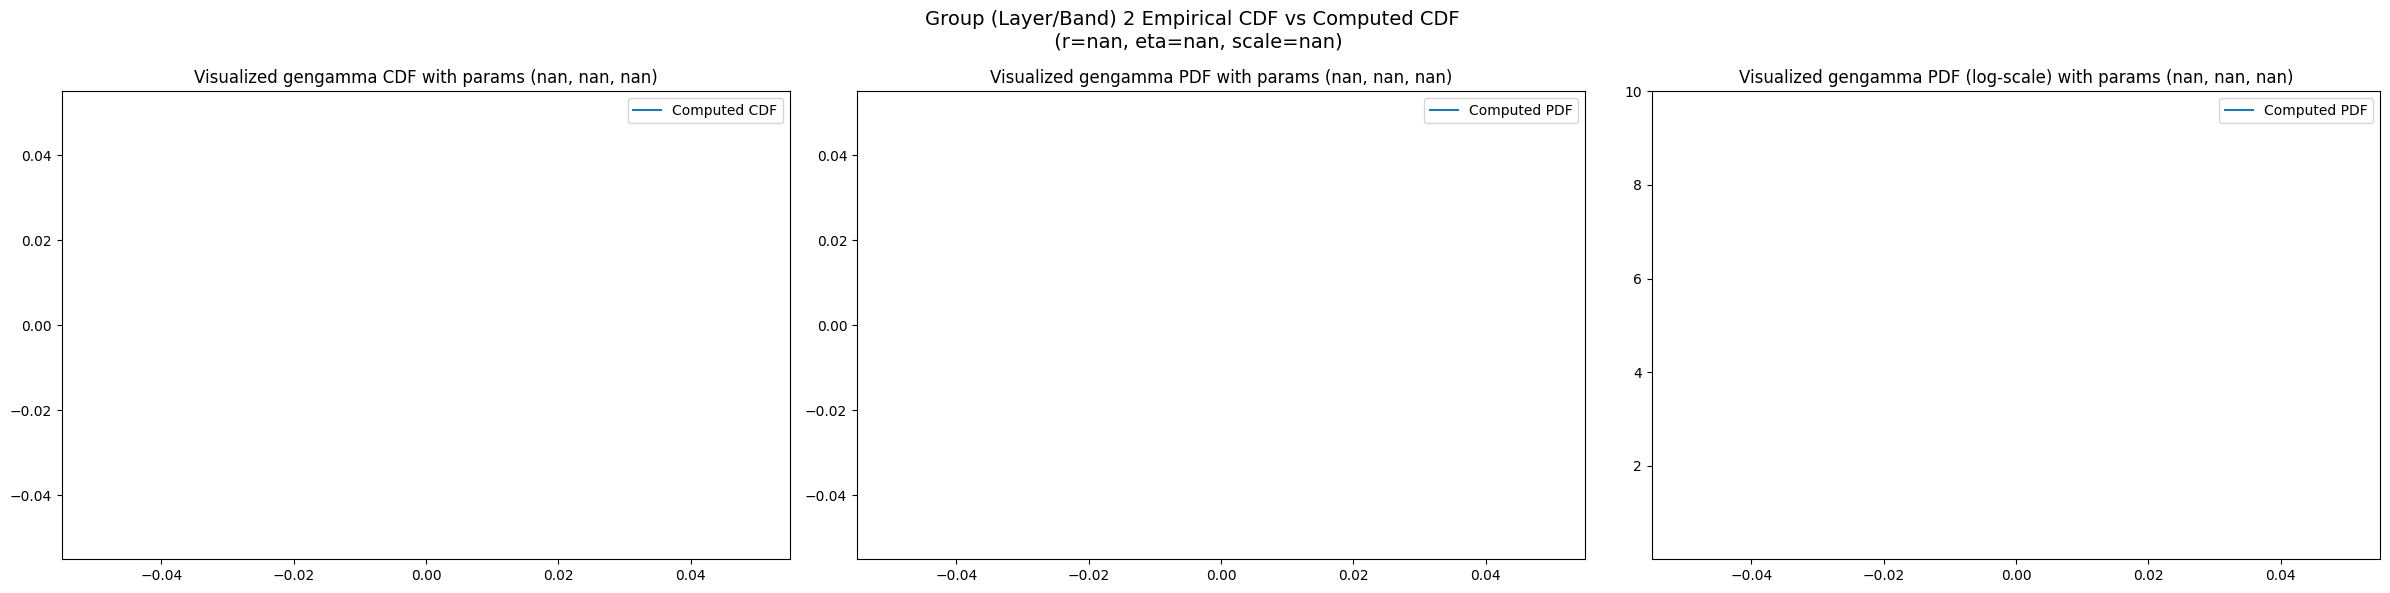

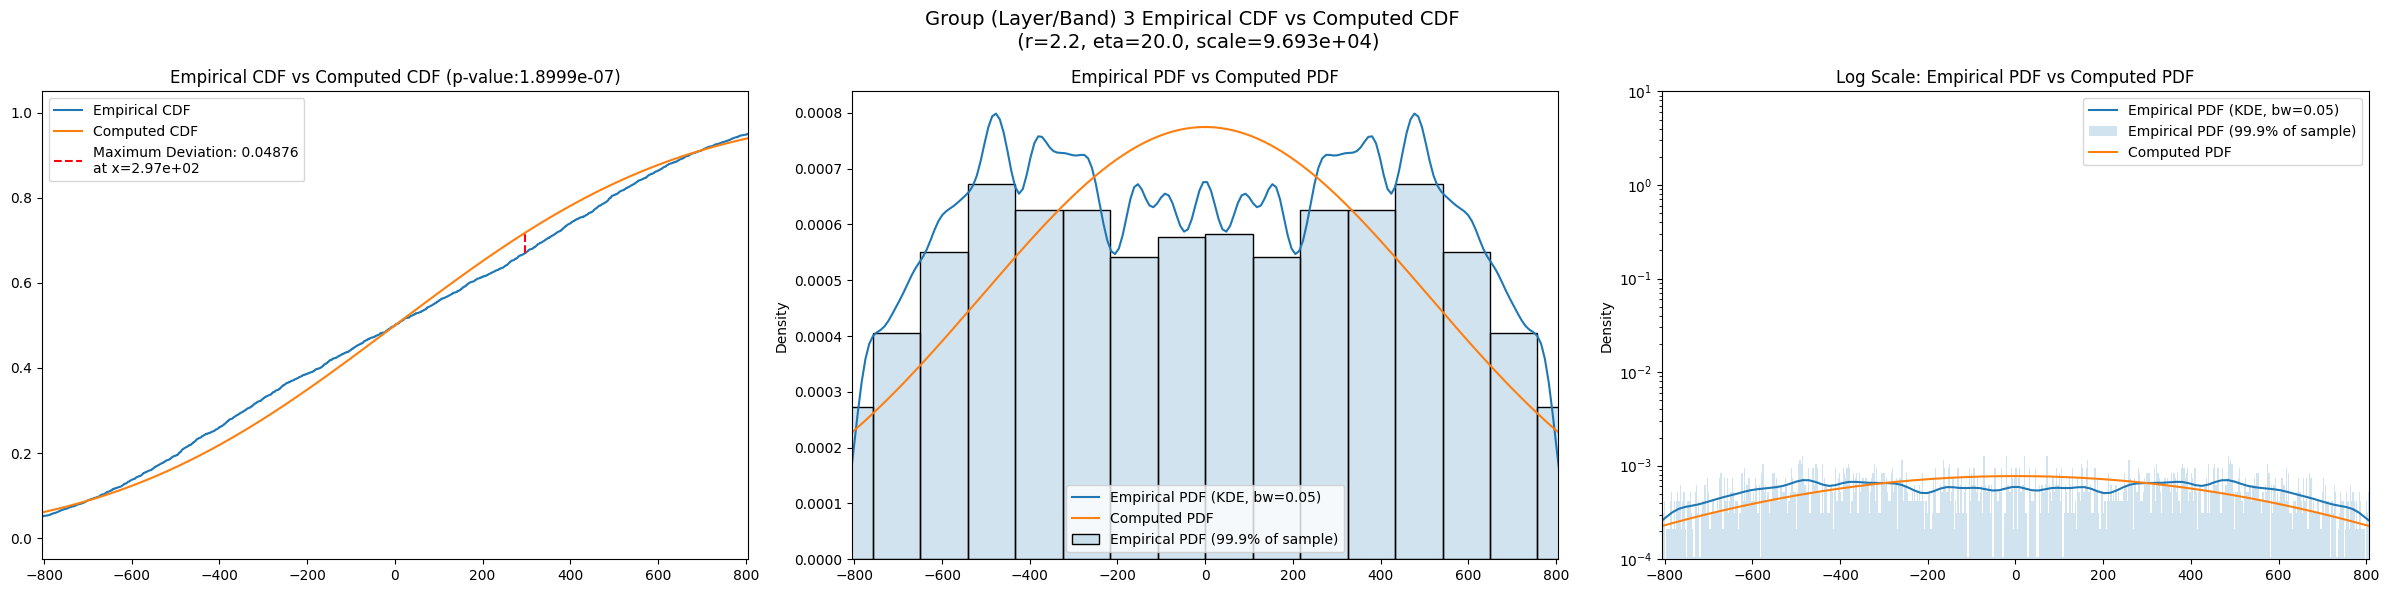

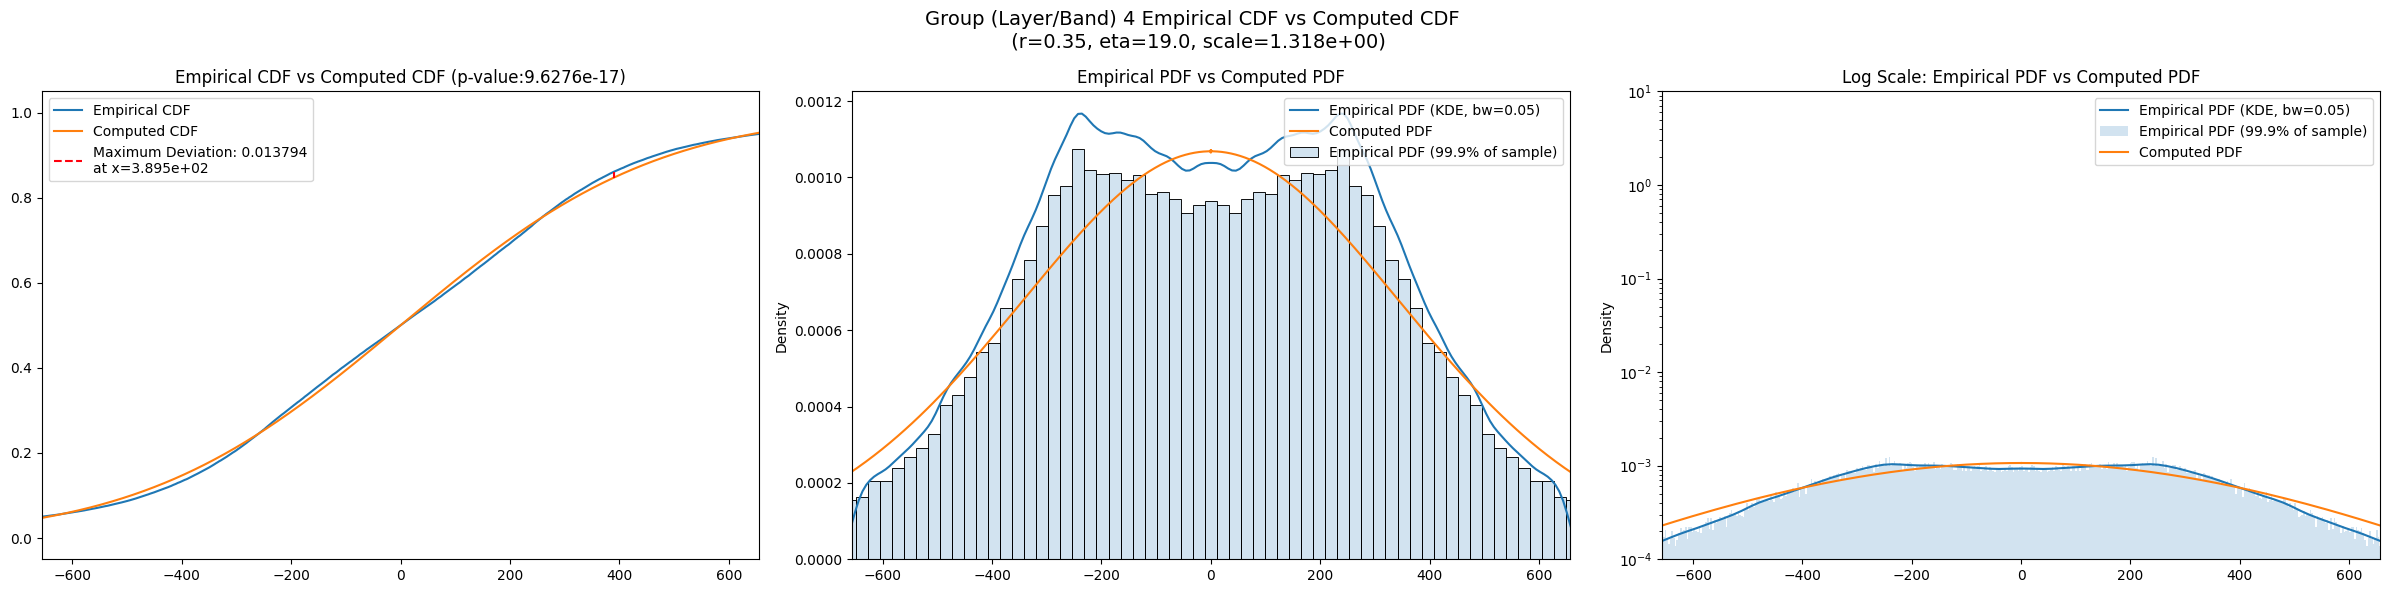

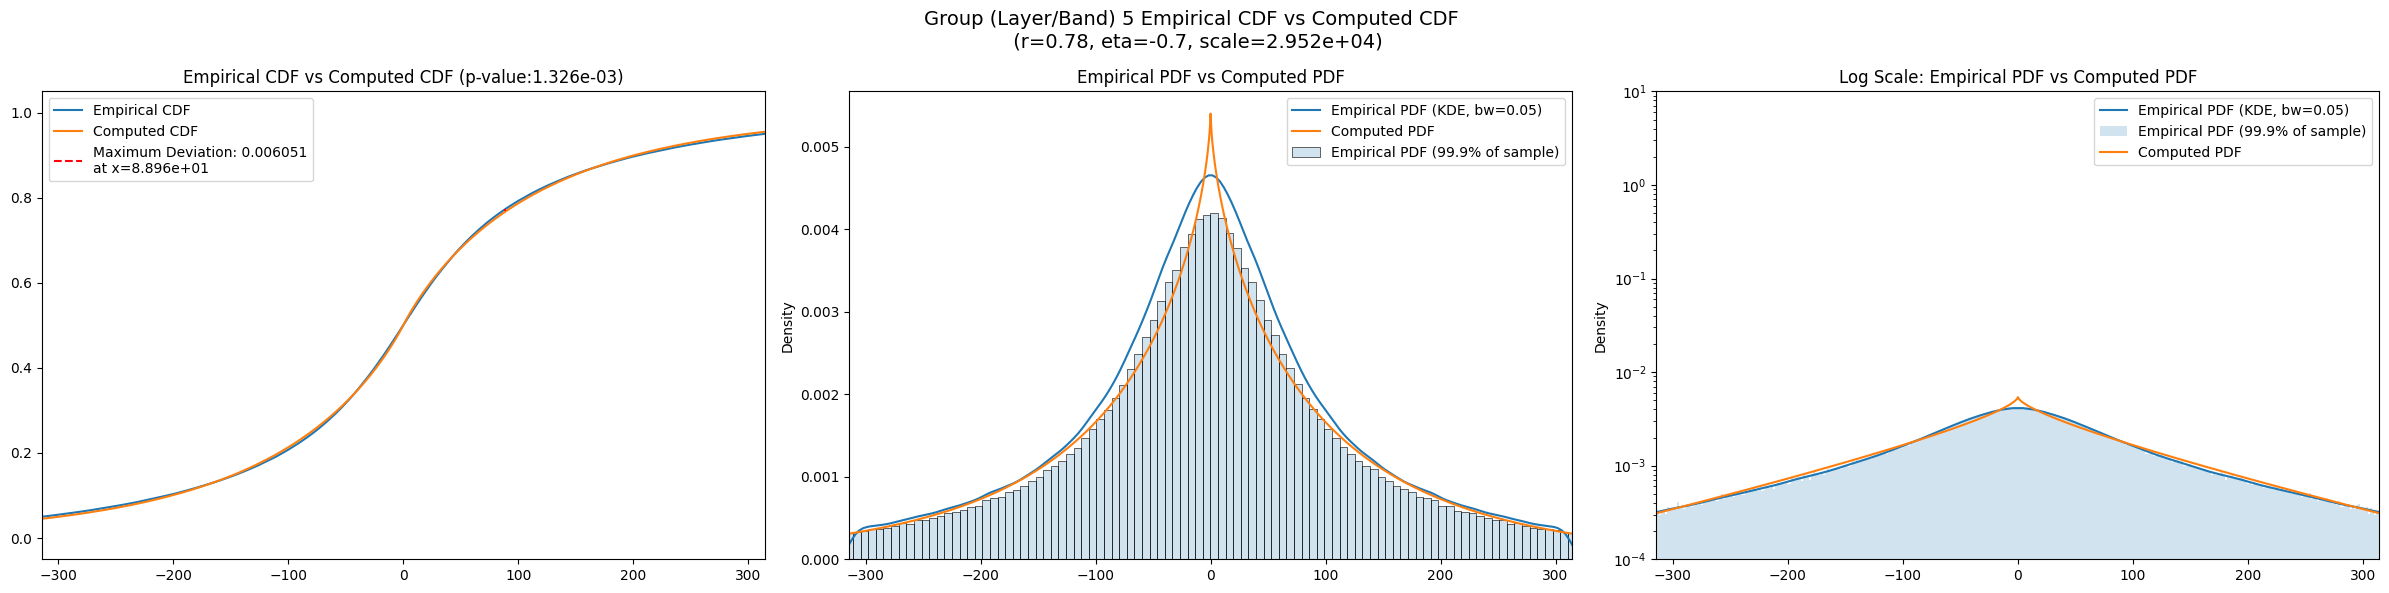

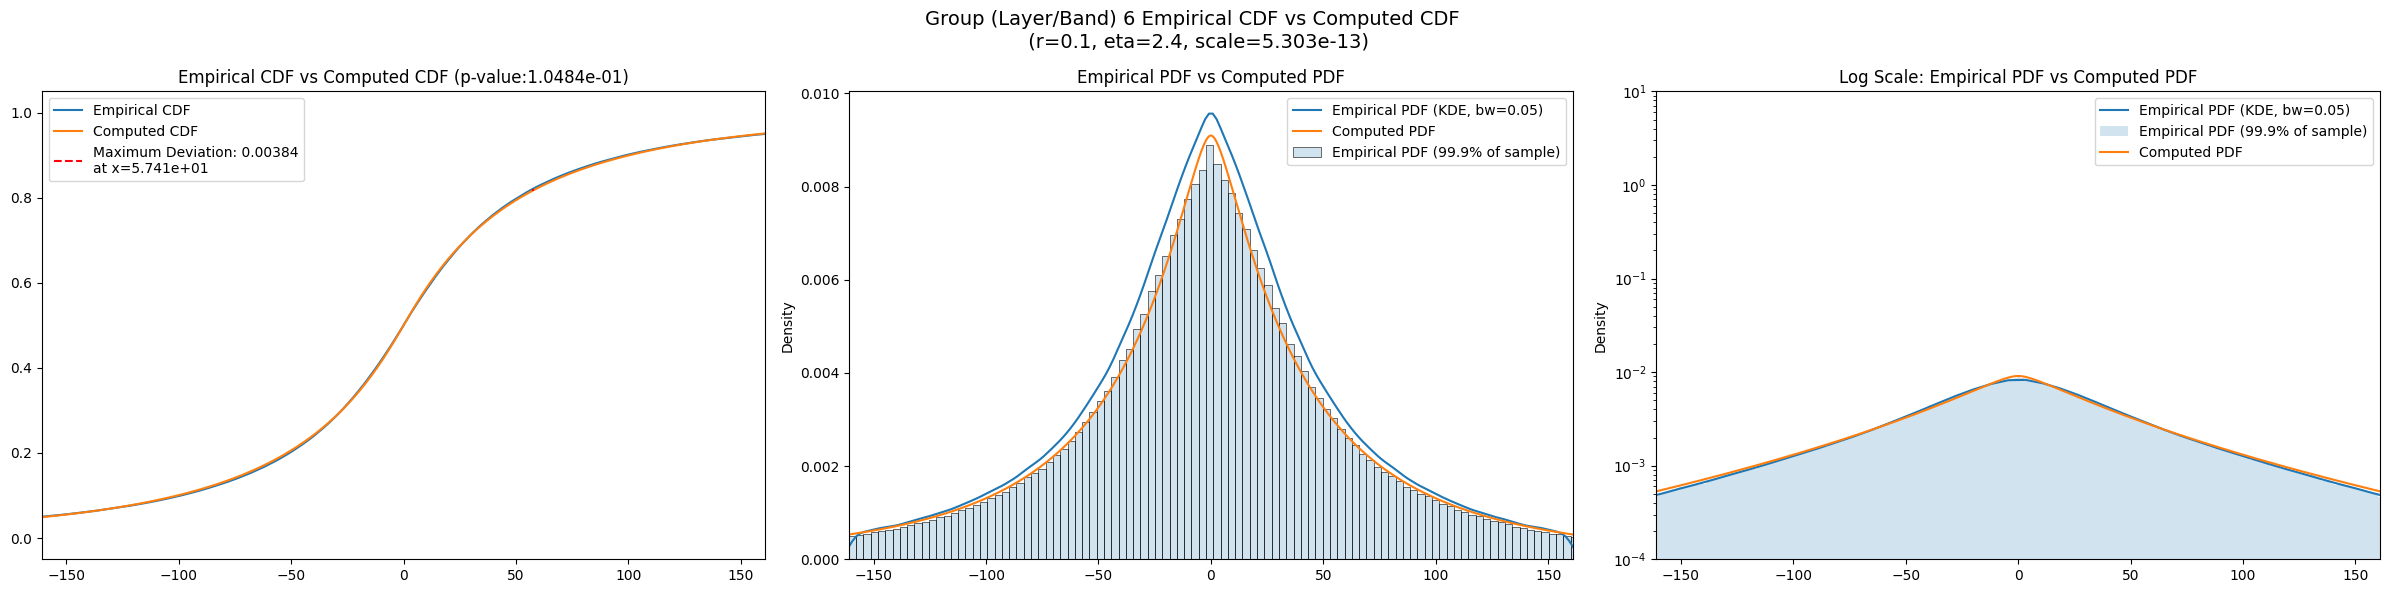

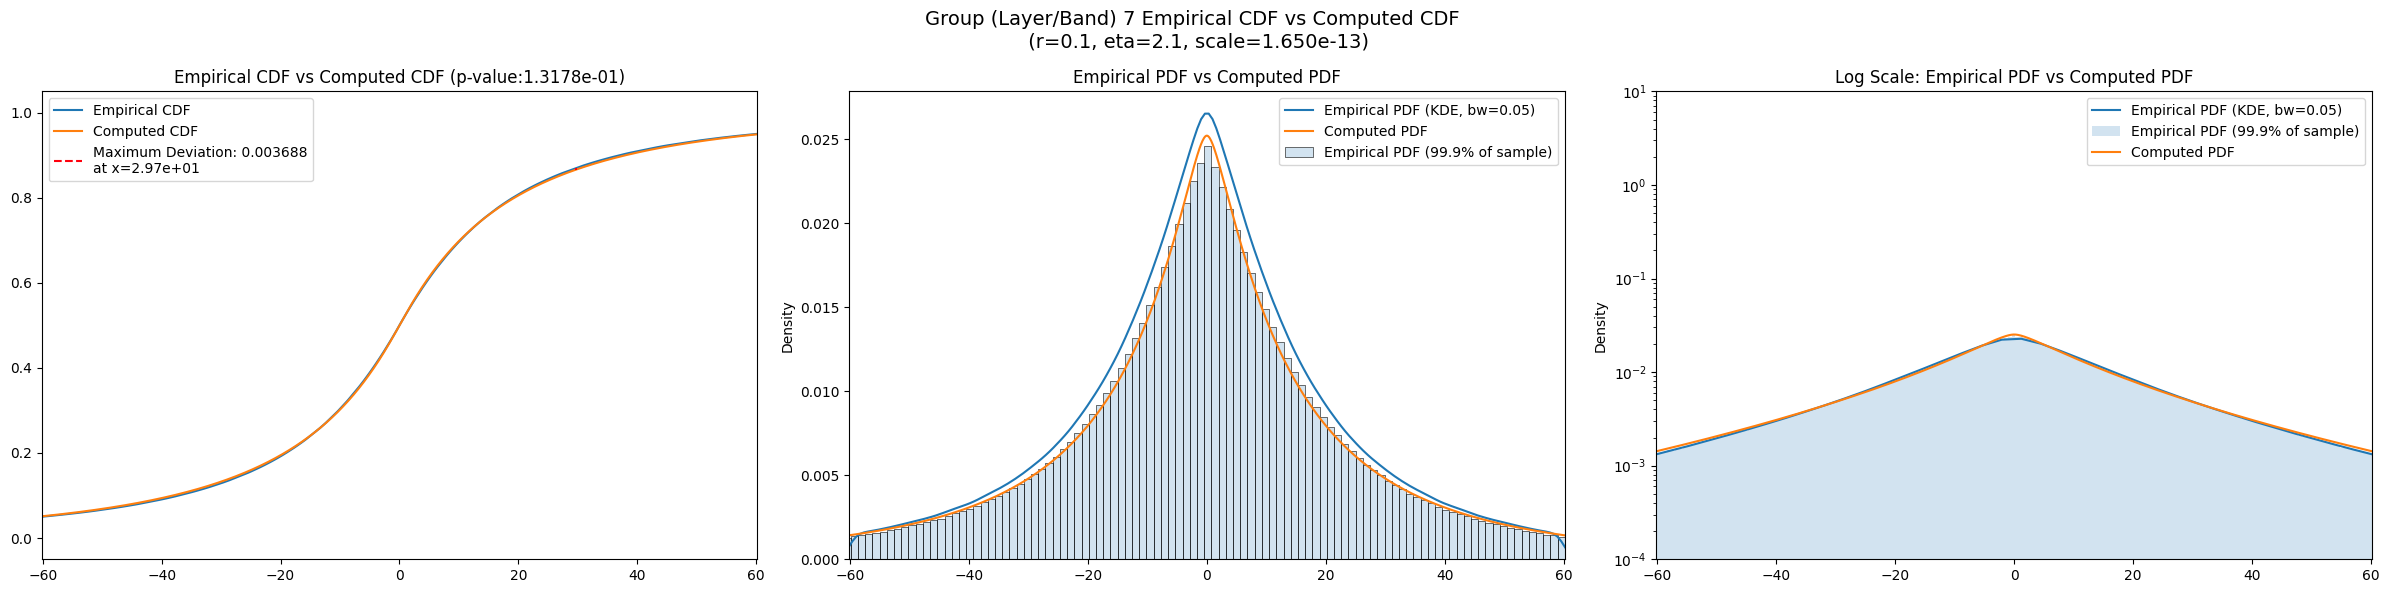

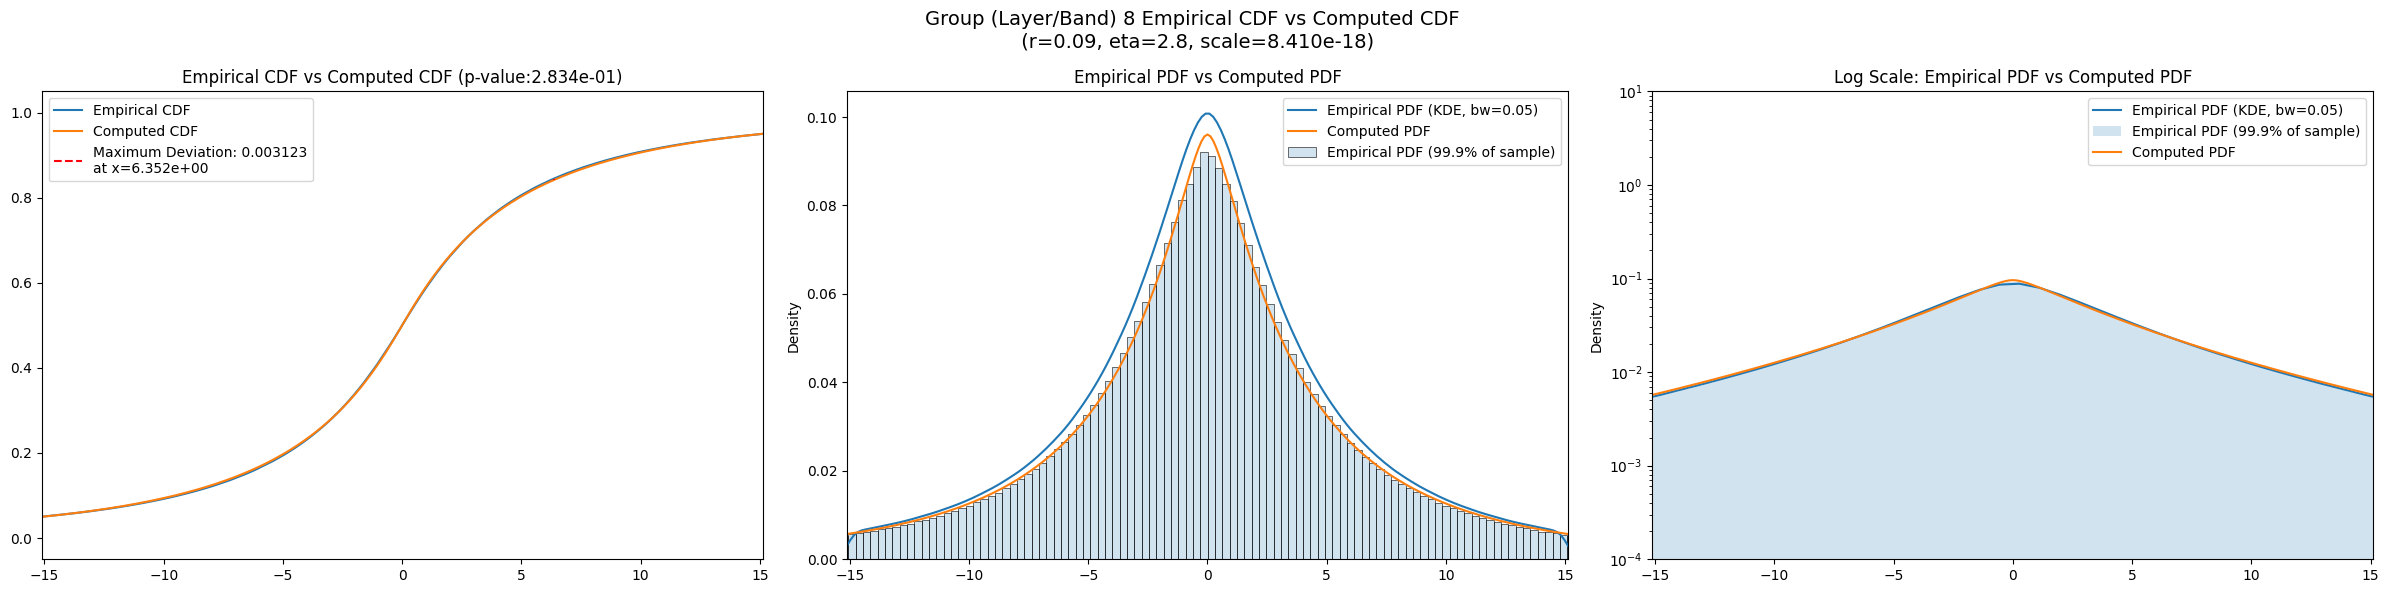

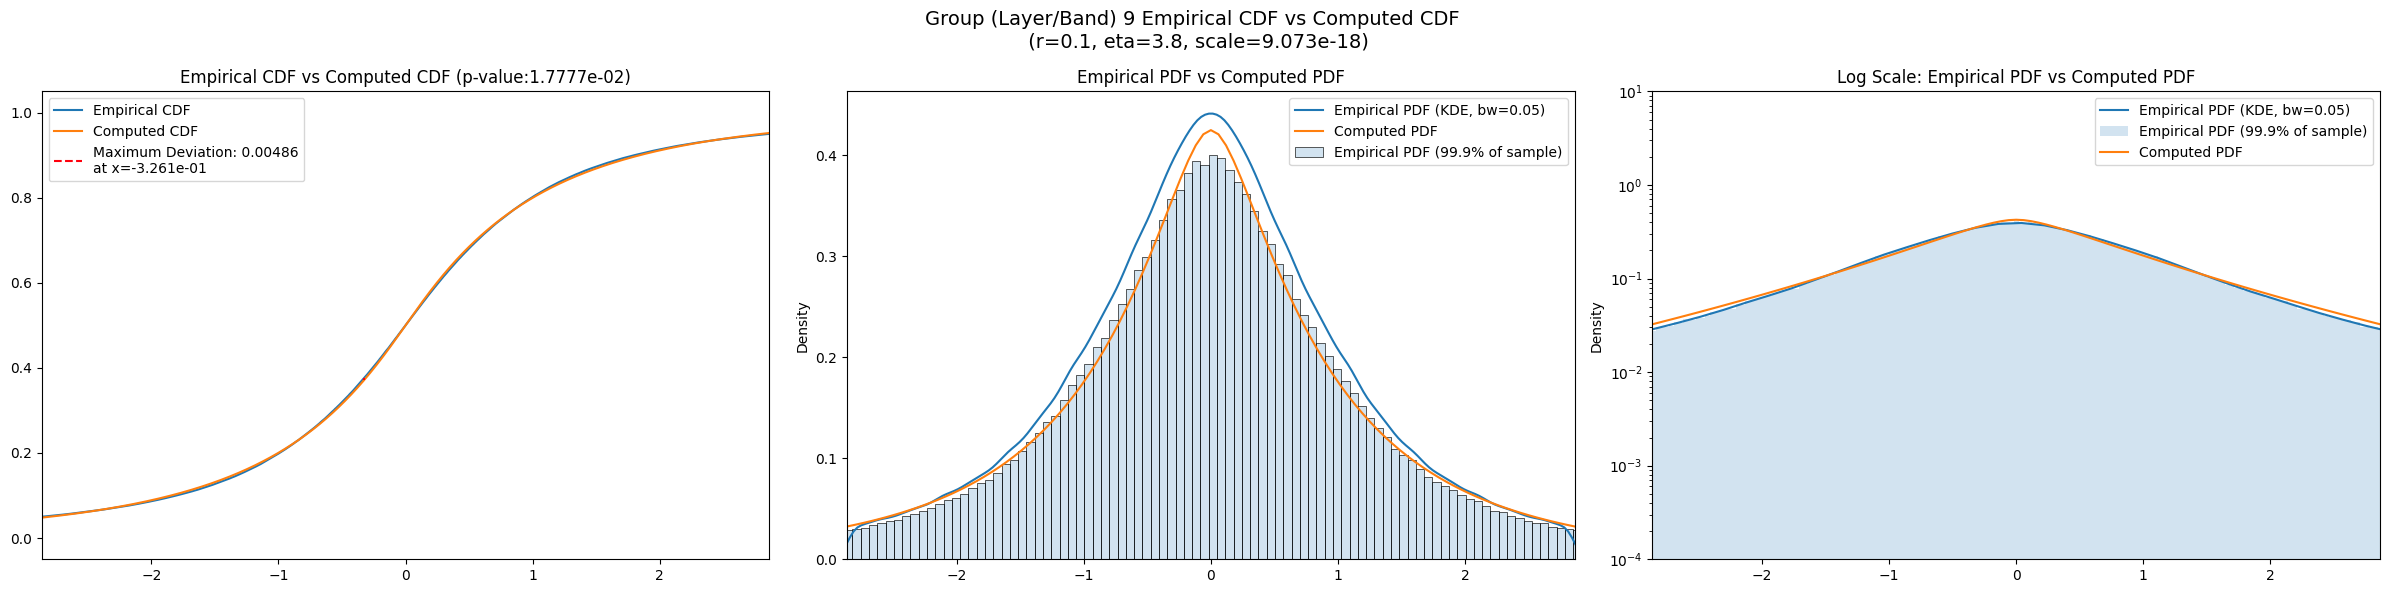

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var      var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2               NaN            NaN            NaN         NaN         NaN   
3      269730.25000  256567.560000  283191.780000   -0.762905   -0.865668   
4      175429.64000  167353.880000  183664.520000    1.248459    1.072484   
5       35103.45300   33078.260000   37192.094000    3.165878    2.714671   
6       13483.66600   12302.890000   14720.538000   10.163432    8.836062   
7        2081.28400    1881.258400    2294.593500   12.775476   10.799274   
8         127.34690     112.202866     150.385480   29.678112   10.853311   
9           5.91954       4.214583      11.399667  575.520200   13.528171   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2              NaN              0                  NaN        NaN   
3        -0.650419           3396             0.048959        2.2   
4         1.431778          98808             0.013879        0.3   
5         3.686968         524004             0.005994        0.8   
6        11.496545        2418270             0.003776        0.1   
7        14.925213       10234344             0.003491        0.1   
8       114.303610       42110360             0.003119        0.1   
9      1555.118400      170911996             0.005269        0.1   

       initial_eta  ...  param_gaussian  kstest_stat_gaussian  \
layer               ...                                         
2              NaN  ...             NaN                   NaN   
3             20.0  ...       575.01800              0.030853   
4             19.0  ...       386.40300              0.017055   
5             -0.7  ...       137.53700              0.041788   
6              2.4  ...        67.97400              0.042743   
7              2.1  ...        25.36930              0.042979   
8              2.4  ...         6.42988              0.042466   
9              3.7  ...         1.32448              0.035134   

       kstest_pval_gaussian  param_laplace  kstest_stat_laplace  \
layer                                                             
2                       NaN            NaN                  NaN   
3              3.046220e-03      507.96300             0.057149   
4              2.137490e-25      350.54800             0.032860   
5              0.000000e+00      120.24400             0.014039   
6              0.000000e+00       60.22160             0.017591   
7              0.000000e+00       22.52270             0.017525   
8              0.000000e+00        5.68228             0.016572   
9              0.000000e+00        1.15595             0.012347   

       kstest_pval_laplace     param_t  kstest_stat_t  kstest_pval_t  \
layer                                                                  
2                      NaN         NaN            NaN            NaN   
3             4.409200e-10  420.031000       0.056590   6.796560e-10   
4             3.966450e-93  292.797000       0.028191   1.182390e-68   
5             3.910520e-90   98.342700       0.014412   5.622510e-95   
6             0.000000e+00   48.053200       0.012990   0.000000e+00   
7             0.000000e+00   17.816600       0.014245   0.000000e+00   
8             0.000000e+00    4.534320       0.013416   0.000000e+00   
9             0.000000e+00    0.934837       0.004492   0.000000e+00   

       kstest_pval_gengamma  
layer                        
2                       NaN  
3              1.633114e-07  
4              1.289105e-16  
5              7.403894e-16  
6              2.238658e-30  
7             8.998605e-109  
8             4.212864e-283  
9              0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                      NaN                      NaN               NaN   
3                 0.048959                 0.023255          0.048959   
4                 0.013879                 0.004319          0.013733   
5                 0.005994                 0.001876          0.005822   
6                 0.003776                 0.000873          0.003776   
7                 0.003491                 0.000425          0.003491   
8                 0.003119                 0.000209          0.002780   
9                 0.005269                 0.000104          0.004983   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                       NaN                  NaN            NaN  
3                  0.030853             0.057149       0.056590  
4                  0.017055             0.032860       0.028191  
5                  0.041788             0.014039       0.014412  
6                  0.042743             0.017591       0.012990  
7                  0.042979             0.017525       0.014245  
8                  0.042466             0.016572       0.013416  
9                  0.035134             0.012347       0.004492

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2                     NaN               NaN     NaN       NaN           NaN   
3           269730.250000          0.048959    2.20      20.0  9.692541e+04   
4           154787.312500          0.013733    0.35      19.0  1.317624e+00   
5            35103.453125          0.005822    0.78      -0.7  2.952425e+04   
6            12587.686000          0.003776    0.10       2.4  5.303439e-13   
7             1910.192400          0.003491    0.10       2.1  1.650053e-13   
8              114.653473          0.002780    0.09       2.8  8.410354e-18   
9                3.539856          0.004983    0.10       3.8  9.072723e-18   

       best_exclude_cutoff  
layer                       
2                      NaN  
3                      0.0  
4                    575.0  
5                      0.0  
6                     75.0  
7                     75.0  
8                     50.0  
9                    225.0

In [21]:
eng.quit()